In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [106]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/halong_quality.csv', index_col='date')

In [107]:
imputer = SimpleImputer(missing_values=np.nan) # Handling missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)


ValueError: Shape of passed values is (1920, 5), indices imply (1920, 6)

In [108]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [109]:
# Dataset splitting
SPLIT = 0.9
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [110]:
n_forecast = 5

In [111]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='tanh'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_7 (Dropout)         (None, 30)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
history = model_gru.fit(X_train, y_train, epochs=20, batch_size=12)

Epoch 1/20
143/143 [==============================] - 5s 16ms/step - loss: 0.0373 - MAE: 0.1406
Epoch 2/20
143/143 [==============================] - 2s 17ms/step - loss: 0.0170 - MAE: 0.0960
Epoch 3/20
143/143 [==============================] - 3s 18ms/step - loss: 0.0134 - MAE: 0.0839
Epoch 4/20
143/143 [==============================] - 2s 12ms/step - loss: 0.0120 - MAE: 0.0767
Epoch 5/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0113 - MAE: 0.0727
Epoch 6/20
143/143 [==============================] - 2s 12ms/step - loss: 0.0102 - MAE: 0.0680
Epoch 7/20
143/143 [==============================] - 2s 12ms/step - loss: 0.0099 - MAE: 0.0663
Epoch 8/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0096 - MAE: 0.0637
Epoch 9/20
143/143 [==============================] - 2s 15ms/step - loss: 0.0094 - MAE: 0.0630
Epoch 10/20
143/143 [==============================] - 2s 17ms/step - loss: 0.0091 - MAE: 0.0620
Epoch 11/20
143/143 [==================

In [113]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


6/6 [==============================] - 0s 4ms/step


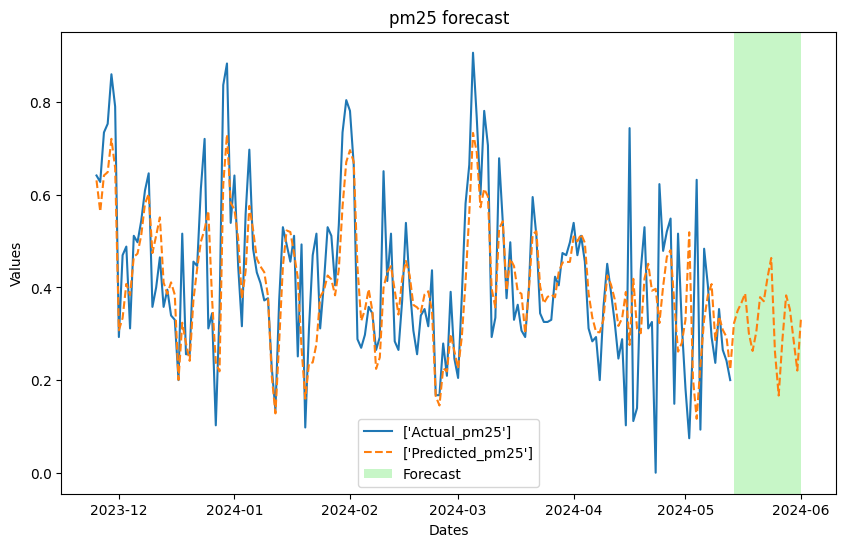

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [115]:
predicted_values

array([[0.6312886 , 0.6322909 , 0.63204646, 0.6349102 , 0.6348323 ],
       [0.56381446, 0.56647116, 0.5685929 , 0.56941354, 0.5693868 ],
       [0.6420326 , 0.6450748 , 0.641595  , 0.6455177 , 0.6480439 ],
       [0.6490245 , 0.65331733, 0.65440464, 0.6548723 , 0.65713733],
       [0.72107446, 0.7227804 , 0.72406334, 0.72513866, 0.7285273 ],
       [0.65852886, 0.6626726 , 0.67163414, 0.6687798 , 0.6713746 ],
       [0.3075156 , 0.31173566, 0.323729  , 0.3167217 , 0.3128732 ],
       [0.33398622, 0.34389585, 0.3360379 , 0.337925  , 0.33743823],
       [0.40775654, 0.42094642, 0.40738532, 0.41068164, 0.413958  ],
       [0.38342503, 0.38959366, 0.37666702, 0.38005486, 0.38641313],
       [0.4659075 , 0.46885273, 0.45646837, 0.46062952, 0.4694835 ],
       [0.47306454, 0.47432724, 0.46614066, 0.4701402 , 0.47777814],
       [0.51272154, 0.50647515, 0.4990556 , 0.50656354, 0.513612  ],
       [0.58095723, 0.5763713 , 0.571928  , 0.57777625, 0.57961625],
       [0.6018592 , 0.5977223 , 0.

In [116]:
predicted_values[:1].size

5

In [117]:
predicted_values_90 = predicted_values[:18]

In [118]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[137.72705  137.94254  137.88998  138.50569  138.48895 ]
 [123.22011  123.7913   124.247475 124.42391  124.41816 ]
 [140.03702  140.69107  139.94293  140.7863   141.32944 ]
 [141.54027  142.46323  142.69699  142.79755  143.28453 ]
 [157.031    157.39778  157.67361  157.90482  158.63338 ]
 [143.58371  144.47461  146.40134  145.78766  146.34554 ]
 [ 68.11585   69.02316   71.60174   70.09517   69.26774 ]
 [ 73.80704   75.93761   74.248146  74.65387   74.54922 ]
 [ 89.667656  92.50348   89.587845  90.29655   91.00097 ]
 [ 84.43638   85.762634  82.983406  83.71179   85.07882 ]
 [102.17011  102.80334  100.1407   101.03535  102.93895 ]
 [103.70888  103.980354 102.22024  103.08014  104.7223  ]
 [112.23513  110.89216  109.29696  110.91116  112.426575]
 [126.90581  125.91983  124.96452  126.22189  126.61749 ]
 [131.39973  130.51028  130.66481  131.56447  131.87408 ]
 [104.01723  103.66377  104.35814  104.73303  104.77456 ]
 [112.05843  112.410324 110.85628  112.08081  113.225975]
 [120.54269  1

In [119]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

In [120]:
predicted_values_90.size

90

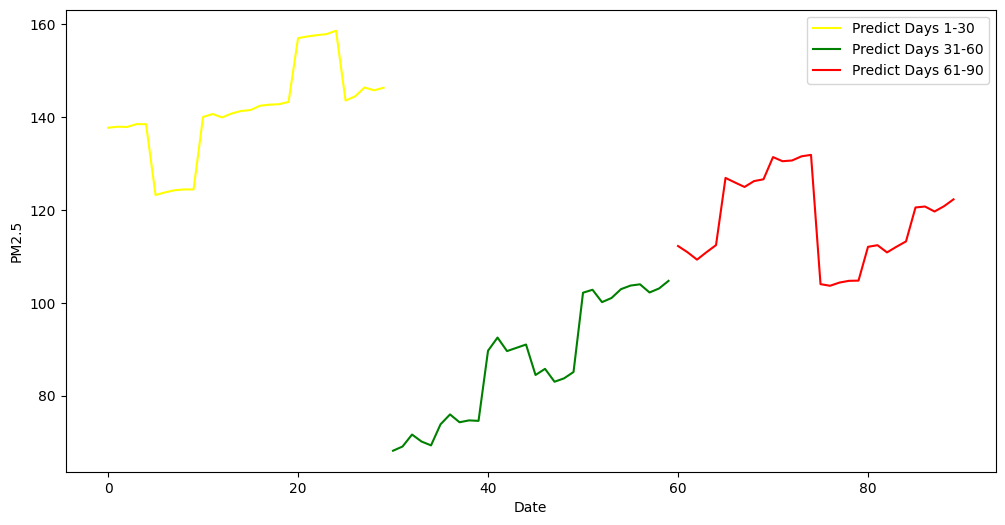

In [121]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (190, 1)
Shape of predicted_values_all: (190, 5)
RMSE: 91.6511577908614
MAE: 87.61924606650082
MAPE: 2071394188225032.0
